In [1]:
# Check if required libraries are installed
!pip freeze | grep matplotlib || pip install matplotlib
!pip freeze | grep pandas || pip install pandas
!pip freeze | grep numpy || pip install numpy

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
import re
import os

matplotlib==3.7.1
matplotlib-inline==0.1.6
pandas==2.0.0
numpy==1.24.2


# Introduction
La volatilité du cours du bitcoin est un sujet d'intérêt majeur pour les investisseurs et les économistes en raison de son impact sur l'économie mondiale. Plusieurs facteurs tels que la demande, l'offre, la réglementation gouvernementale et les nouvelles technologies sont connus pour influencer le prix du bitcoin. Toutefois, l'impact des acteurs du marché est encore mal compris. Ce projet vise à étudier l'impact des 100 principaux acteurs sur le cours du bitcoin en utilisant différentes données pour la période de 2015 à 2017.

Notre étude se compose de deux parties distinctes. Tout d'abord, nous analyserons l'impact des interactions et de leurs valeurs sur le cours du bitcoin. Pour ce faire, nous avons découpé le cours du bitcoin en plusieurs phases, respectivement haussière, baissière et stagnante, représentées par des couleurs différentes. Ensuite, nous avons choisi plusieurs phases représentatives de chaque type et avons étudié les interactions et leurs valeurs durant les semaines précédentes. Si les acteurs influencent le cours du bitcoin, nous nous attendons à voir une corrélation entre le nombre et la valeur des interactions et le cours du bitcoin une semaine après.

Dans la seconde partie, nous examinons l'impact du volume des acteurs sur le cours du bitcoin. Nous avons calculé la somme des volumes des acteurs puis avons filtré ces acteurs pour étudier leur impact. Nous cherchons des corrélations entre le volume des acteurs et les différentes phases du cours du bitcoin. Pour mieux comprendre l'impact des acteurs sur le cours du bitcoin, nous avons également calculé la moyenne mobile pondérée par le volume (VWMA) et avons analysé le croisement du cours du bitcoin avec cette VWMA. En combinant ces analyses, nous espérons apporter une meilleure compréhension de l'impact des acteus du marché sur le cours du bitcoin.

## Import data

In [2]:
btc_df =  pd.read_csv("data/timeseries/external.csv")
btc_df.head()

,Unnamed: 0,date,PriceUSD,HashRate
0,2190,2015-01-02,315.942732,333345.017260
1,2191,2015-01-03,285.647310,327284.198765
2,2192,2015-01-04,263.334575,347486.927083
3,2193,2015-01-05,275.003852,315162.561773
4,2194,2015-01-06,287.549521,319203.107437


In [3]:
actors_df = pd.read_csv("data/timeseries/blockchain_by_actor.csv")
actors_df.head()

,Unnamed: 0,year,month,day,identity,received,nb_received,date,sum_fee,mean_fee_for100,nb_transactions,sent,self_spent,self_spent_estimated,nb_spent,spent
0,0,2015.0,1.0,1.0,HappyCoins.com,1.377590e+09,4.0,2015-01-01,49596.0,0.004957,4.0,1.277500e+09,0.0,0.0,8.0,1.277500e+09
1,1,2015.0,1.0,1.0,821,2.476057e+09,5.0,2015-01-01,10000.0,0.000851,1.0,1.174552e+09,0.0,0.0,2.0,1.174552e+09
2,2,2015.0,1.0,1.0,FortuneJack.com,1.201470e+08,29.0,2015-01-01,83000.0,0.194670,11.0,1.541127e+08,14158970.0,14158970.0,22.0,1.399538e+08
3,3,2015.0,1.0,1.0,396,1.906135e+10,70.0,2015-01-01,540000.0,0.023738,54.0,1.842989e+10,0.0,0.0,108.0,1.842989e+10
4,4,2015.0,1.0,1.0,SatoshiMines.com,7.401319e+08,193.0,2015-01-01,740000.0,0.447934,45.0,1.813624e+09,35044568.0,35044568.0,84.0,1.778579e+09


## Clean

In [4]:
btc_df = btc_df.drop(['Unnamed: 0'], axis=1)
btc_df.date = pd.to_datetime(btc_df.date)

In [5]:
btc_df.head()

,date,PriceUSD,HashRate
0,2015-01-02,315.942732,333345.017260
1,2015-01-03,285.647310,327284.198765
2,2015-01-04,263.334575,347486.927083
3,2015-01-05,275.003852,315162.561773
4,2015-01-06,287.549521,319203.107437


In [6]:
actors_df =actors_df.drop(['year', 'month', 'day', 'Unnamed: 0'], axis=1)
actors_df.head()

,identity,received,nb_received,date,sum_fee,mean_fee_for100,nb_transactions,sent,self_spent,self_spent_estimated,nb_spent,spent
0,HappyCoins.com,1.377590e+09,4.0,2015-01-01,49596.0,0.004957,4.0,1.277500e+09,0.0,0.0,8.0,1.277500e+09
1,821,2.476057e+09,5.0,2015-01-01,10000.0,0.000851,1.0,1.174552e+09,0.0,0.0,2.0,1.174552e+09
2,FortuneJack.com,1.201470e+08,29.0,2015-01-01,83000.0,0.194670,11.0,1.541127e+08,14158970.0,14158970.0,22.0,1.399538e+08
3,396,1.906135e+10,70.0,2015-01-01,540000.0,0.023738,54.0,1.842989e+10,0.0,0.0,108.0,1.842989e+10
4,SatoshiMines.com,7.401319e+08,193.0,2015-01-01,740000.0,0.447934,45.0,1.813624e+09,35044568.0,35044568.0,84.0,1.778579e+09


## Functions

### Mean, period

In [7]:
def variation_auround_median(x):
    return abs(x[1] - np.median(x)) - np.median(abs(x - np.median(x)))

def calculate_spike(data):
    # calculate the rolling median of the data
    rolling_median = data.rolling(60).median()
    
    # calculate the relative madness of the data
    relative_madness_values = data.rolling(60).apply(variation_auround_median)
    
    # check if the value is above a certain threshold
    if data.iloc[-1] > rolling_median.iloc[-1] + relative_madness_values.iloc[-1] + 20:
        return 1
    if data.iloc[-1] < rolling_median.iloc[-1] + relative_madness_values.iloc[-1] - 20:
        return -1
    return 0

In [8]:
def period_date(dates, ax, phase):
    diffs = []
    for i in range(len(dates) - 1):
        diff = dates[i+1][0] - dates[i][0]
        diffs.append((diff, dates[i][0], dates[i+1][0], dates[i][1]))

    res = []
    for color in set([x[3] for x in diffs]):
        color_diffs = [x for x in diffs if x[3] == color]
        color_diffs_sorted = sorted(color_diffs, reverse=True)[:2]
        for diff, date1, date2, color in color_diffs_sorted:
            if (phase):
                ax.axvspan(date1, date2, alpha=0.3, color=color)
            res.append((date1, date2, color))
    return res

In [9]:
def create_spike(data, btc, ax, phase, n):
    spike_series = data['PriceUSD'].rolling(60).apply(calculate_spike)

    data['Upward_phase'] = False
    data['Downward_phase'] = False
    data['Stagnant_phase'] = False

    color = 'b'
    date = btc['date'][0]
    dates = [(date, color)]

    for i in range(1, len(spike_series)):
        last_color = color
        if spike_series[i] == 1 and data['PriceUSD'][i] > data['PriceUSD'][i-1]:
            color = 'g'
            ax.plot(data.index[i:], data['PriceUSD'][i:], color=color)
            data.loc[data.index[i], 'Upward_phase'] = True
        elif spike_series[i] == -1 and data['PriceUSD'][i] < data['PriceUSD'][i-1]:
            color = 'r'
            ax.plot(data.index[i:], data['PriceUSD'][i:], color=color)
            data.loc[data.index[i], 'Downward_phase'] = True
        elif spike_series[i] == 0 and data['PriceUSD'][i] < data['PriceUSD'][i-1]:
            color = 'b'
            ax.plot(data.index[i:], data['PriceUSD'][i:], color=color)
            data.loc[data.index[i], 'Stagnant_phase'] = True
        if (color != last_color):
            date = data.index[i]
            dates.append((date, color))

    del dates[0]
    dates = period_date(dates, ax, phase)
    return dates

In [10]:
def calculate_mean(data):
    # Calcule de la moyenne mobile sur la colonne de prix
    data['mean'] = data['PriceUSD'].rolling(window=30).mean()

    # Décaler d'un jour vers le haut
    data['mean_shifted'] = data['mean'].shift(1)
    data['price_shifted'] = data['PriceUSD'].shift(1)

    # Ajouter une colonne pour les croisements de prix et de moyenne mobile
    data['crossings'] = None

    # Trouver les croisements de haut en bas
    data.loc[(data['price_shifted'] > data['mean_shifted']) & (data['PriceUSD'] < data['mean']), 'crossings'] = 'Crossing from top to bottom'

    # Trouver les croisements de bas en haut
    data.loc[(data['price_shifted'] < data['mean_shifted']) & (data['PriceUSD'] > data['mean']), 'crossings'] = 'Crossing from bottom to top'
    
    data = data.drop(['mean_shifted', 'price_shifted'], axis=1)
    return data

In [71]:
def print_cross(data, ax):
    data['vwma_shifted'] = data['vwma'].shift(1)
    data['price_shifted'] = data['PriceUSD'].shift(1)
    data['crossings'] = None
    
    data.loc[(data['price_shifted'] > data['vwma_shifted']) & (data['PriceUSD'] < data['vwma']), 'crossings'] = 'Crossing from top to bottom'
    data.loc[(data['price_shifted'] < data['vwma_shifted']) & (data['PriceUSD'] > data['vwma']), 'crossings'] = 'Crossing from bottom to top'
    
    data = data.reset_index()    
    ax.scatter(data.loc[data['crossings'] == 'Crossing from top to bottom', 'date'], data.loc[data['crossings'] == 'Crossing from top to bottom', 'PriceUSD'], c='r', marker='v', s=100, label='Crossing from top to bottom')
    ax.scatter(data.loc[data['crossings'] == 'Crossing from bottom to top', 'date'], data.loc[data['crossings'] == 'Crossing from bottom to top', 'PriceUSD'], c='g', marker='^', s=100, label='Crossing from bottom to top')
    data = data.set_index('date', inplace=True)


In [12]:
def print_corr(data):
    # Colorbar correlation
    plt.subplots(figsize=(10,8))
    plt.imshow(data.corr())
    plt.yticks(range(18), data.corr())
    plt.xticks(range(18), data.corr(), rotation='vertical')
    plt.colorbar()

In [13]:
def error(data, price, hashrate, period, phase):
    if (period == False) & phase:
        print("If you want to see phase you must set period at True to")

### Transactions by day

In [14]:
def list_dates(start_date, end_date):
    #start_date = datetime.strptime(start_date, '%Y-%m-%d')
    #end_date = datetime.strptime(end_date, '%Y-%m-%d')
    delta = timedelta(days=1)
    dates = []
    while start_date <= end_date:
        str_date = start_date.strftime("%Y-%m-%d") 
        str_date = re.sub(r'-0', '-', str_date)
        dates.append(str_date)
        start_date += delta
    return dates

In [15]:
def get_best_actors(start_date, end_date):
    dates = list_dates(start_date, end_date)
    df_list = []
    for date in dates:
        file_path = 'data/networks/' + date + '.csv'
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path)
            df_list.append(temp_df)
            
            if (len(df_list) == 2):
                df = df_list[0]
                df2 = df_list[1]
                col = df2['value'].copy()
                df2 = df2.assign(value_count=col)
                df2 = df2.groupby(['Source', 'Target']).agg({'value_count': 'count', 'value': 'sum'}).reset_index().rename(columns={'value_count': 'interactions', 'value': 'values'})
                merged = pd.merge(df, df2, on=['Source', 'Target'], how='outer').fillna(0)
                merged['interactions'] = merged['interactions_x'] + merged['interactions_y']
                merged['values'] = merged['values_x'] + merged['values_y']
                merged = merged.drop(['interactions_x', 'interactions_y', 'values_x', 'values_y'], axis=1)
                df_list = [merged]
            else:
                col = df_list[0]['value'].copy()
                df_list[0] = df_list[0].assign(value_count=col)
                df_list[0] = df_list[0].groupby(['Source', 'Target']).agg({'value_count': 'count', 'value': 'sum'}).reset_index().rename(columns={'value_count': 'interactions', 'value': 'values'})
    df = df_list[0]

    top_sources = set(df.sort_values('interactions', ascending=False)['Source'].head(100).tolist())
    top_targets = set(df.sort_values('interactions', ascending=False)['Target'].head(100).tolist())

    common_actors = top_sources.intersection(top_targets) 
    return df_list[0], common_actors

In [16]:
def print_values_interactions(data, color, ax):
    total_interactions = data['interactions'].sum()
    total_volume = data['values'].sum()

    # Afficher la somme des interactions dans la barre correspondante
    ax.bar(0, total_volume, width=0.5, label='Total volume', color=color)
    ax.text(0, total_volume, f"{total_volume}", ha='center', va='bottom')

    ax2 = ax.twinx()
    # Afficher la somme du volume total dans la barre correspondante
    ax2.bar(1, total_interactions, width=0.5, label='Total interactions', color=color)
    ax2.text(1, total_interactions, f"{total_interactions}", ha='center', va='bottom')

    ax.set_ylim([0, 1e16])
    ax2.set_ylim([0, 100000])

    # Configurer l'axe des x et des y
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Values', 'Interactions'])
    ax.set_ylabel('Total')
    
    title = ""
    if (color == 'g'):
        title = "Updward phase"
    if (color == 'r'):
        title = "Downward phase"
    if (color == 'b'):
        title = "Stagante phase"
    ax.set_title(title)

In [17]:
def sum_interaction_values(dates):
    delta = timedelta(days=7)

    figure, axis = plt.subplots(3, 2, figsize=(16,10))
    i = 0
    for (date1, date2, color) in dates:
        # one week before phase
        date2 = date1
        date1 = date1 - delta
        df, _ = get_best_actors(date1, date2)
        print_values_interactions(df, color, axis[int((i/2))][i%2])
        str_date1 = date1.strftime('%Y-%m-%d')
        str_date2 = date2.strftime('%Y-%m-%d')
        axis[int((i/2))][i%2].text(0.1, 0.9, str_date1 + " -> " + str_date2, transform=axis[int((i/2))][i%2].transAxes, fontsize=14)
        i += 1    

    plt.show()

In [18]:
def transaction_by_day(listactor, start_date, end_date):
    #Create date list
    dates = list_dates(start_date, end_date)

    #Create figure
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()

    ax1.set_ylim(-0.5, len(listactor)-0.5)
    ax1.set_yticks(np.arange(len(listactor)))
    ax1.set_yticklabels(listactor)

    ax2.set_ylim(-0.5, len(listactor)-0.5)
    ax2.set_yticks(np.arange(len(listactor)))
    ax2.set_yticklabels(listactor)
    
    n = 2*len(dates) + 1
    new_list = ['']*n
    
    for i in range(n):
        if i % 2 == 0:
            new_list[i] = ''
            ax1.plot([0, n], [i/2, i/2], c='g', alpha=0.5)
        else:
            new_list[i] = dates[i//2]
    
    x_index = 0
    #Loop on all date
    for date in dates:
        file_path = 'data/networks/' + date + '.csv'
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path)
            temp_df = temp_df[temp_df['Source'].isin(listactor)]
            temp_df = temp_df[temp_df['Target'].isin(listactor)]
            max_value = temp_df['value'].max()
            
            for i, row in temp_df.iterrows():
                y1 = [j for j, x in enumerate(listactor) if x == row['Source']][0]
                y2 = [j for j, x in enumerate(listactor) if x == row['Target']][0]
                ax1.plot([x_index, x_index+2], [y1, y2], c='r',alpha=0.1)
                ax1.scatter(x_index, y1, s=(((row['value'] / max_value)*100)*5), color='b')
                ax1.scatter(x_index + 2, y2, s=(((row['value'] / max_value)*100)*5), color='b')
        x_index += 2

    ax1.set_xticks(list(range(n)))
    ax1.set_xticklabels(new_list)

### Daily Balance

In [19]:
def plot_profitability(data,identities=[]):
    data = data.drop('date', axis=1)
    data = data.groupby('identity').sum()

    # reset the index so that 'identity' becomes a regular column
    data = data.reset_index()
    
    if (len(identities) != 0):
        data  = data[data["identity"].isin(identities)]
    
    
    data['net_flow'] = data['received'] - data['sent'] - data['self_spent_estimated']
    data['profitable'] = data['net_flow'] >= 0
    profitability_counts = data['profitable'].value_counts()
    labels = [f"Profitable ({profitability_counts[False]})", f"Unprofitable ({profitability_counts[True]})"]
    plt.pie(profitability_counts, labels=labels)
    plt.title('Profitability of Actors')
    plt.show()
    return data
    

In [20]:
def profit_by_day_by_actor(actors_df):
    
    btc_df = pd.read_csv("data/timeseries/external.csv")
    #actors_df.loc[:, 'date'] = pd.to_datetime(actors_df['date'])
    btc_df.loc[:,'date'] = pd.to_datetime(btc_df['date'])
    actors_df.loc[:, 'date'] = pd.to_datetime(actors_df['date'])


    # Merge the actors_df and btc_df dataframes on the "date" column
    merged_df = actors_df.merge(btc_df, on='date')

    # Calculate the difference between "received" and "spent" for each row
    merged_df['diff'] = merged_df['received'] - (merged_df['spent'] - merged_df['self_spent_estimated'])

    # Multiply the difference by the "PriceUSD" for that day
    merged_df['amount_usd'] = merged_df['diff'] * merged_df['PriceUSD']

    # Drop the unnecessary columns from the merged dataframe
    adios = ['sent','received', 'spent', 'PriceUSD', 'nb_received', 'sum_fee', 'mean_fee_for100', 'nb_transactions', 'self_spent', 'self_spent_estimated', 'nb_spent', 'HashRate']
    merged_df = merged_df.drop(adios, axis=1)

    # Rename the remaining columns to make them more descriptive
    merged_df = merged_df.rename(columns={'identity': 'Identity', 'date': 'Date', 'amount_usd': 'Amount (USD)'})
    return merged_df

In [21]:
def remove_extreme_players(test_df):
    df_grouped = test_df.groupby(['Identity'])['Amount (USD)'].agg(['sum', 'std']).reset_index()

    Q1 = df_grouped['sum'].quantile(0.25)
    Q3 = df_grouped['sum'].quantile(0.75)
    IQR = Q3 - Q1

    # Define a threshold for outliers
    threshold = 1.5

    # Remove outliers that lie outside the threshold
    df_filtered = df_grouped[(df_grouped['sum'] >= Q1 - threshold*IQR) & (df_grouped['sum'] <= Q3 + threshold*IQR)]
    return df_filtered

In [22]:
def remove_outliers(test_df):
    # Group the DataFrame by 'Identity' and compute sum and std of 'Amount (USD)'
    df_grouped = test_df.groupby(['Identity'])['Amount (USD)'].agg(['sum', 'std']).reset_index()

    # Create boxplot of 'sum' column in df_grouped
    plt.boxplot(df_grouped['sum'], vert=False)

    # Calculate quartiles and IQR of 'sum' column
    Q1 = df_grouped['sum'].quantile(0.25)
    Q3 = df_grouped['sum'].quantile(0.75)
    IQR = Q3 - Q1

    # Define threshold for outliers
    threshold = 1.5

    # Calculate upper and lower bounds for outliers
    upper = Q3 + threshold*IQR
    lower = Q1 - threshold*IQR

    # Plot the upper and lower bounds as horizontal lines
    plt.axvline(x=upper, color='r', linestyle='--')
    plt.axvline(x=lower, color='r', linestyle='--')

    # Plot the values in 'sum' column of df_grouped as red circles
    plt.plot(df_grouped['sum'], [1]*len(df_grouped), 'ro')

    # Remove outliers from 'sum' column of df_grouped
    df_filtered = df_grouped[(df_grouped['sum'] >= lower) & (df_grouped['sum'] <= upper)]

    # Plot the remaining values as green dots
    plt.plot(df_filtered['sum'], [1]*len(df_filtered), 'go')

    plt.xlabel('Sum of Amount (USD)')
    plt.title('Distribution of Sum of Amount (USD) with Outliers')
    plt.show()

    return df_filtered

In [23]:
def identities_to_keep_corrected(actors_df):
        identities_to_keep = actors_df['Identity'].unique()
        return identities_to_keep

In [24]:
def trading_volume(filtered_df, btc_df):
    grouped_df = filtered_df.groupby('date').sum()
    grouped_df = grouped_df.reset_index()
    grouped_df['real_spent'] = grouped_df['sent'] - grouped_df['self_spent_estimated']
    grouped_df['daily_balance'] = grouped_df['received'] - grouped_df['real_spent']
    adios = ['sent', 'spent', 'nb_received', 'sum_fee', 'mean_fee_for100','Unnamed: 0', 'nb_transactions', 'self_spent', 'self_spent_estimated', 'nb_spent']
    adios= []
    grouped_df = grouped_df.drop(adios, axis=1)
    
    merged_df = profit_by_day_by_actor(filtered_df)
    merged_df['date'] = pd.to_datetime(actors_df['date'])
    #btc_df['date'] = pd.to_datetime(btc_df['date'])

    merged_df = pd.merge(grouped_df, btc_df, on='date')
    merged_df['abs_balance'] = merged_df['daily_balance'].abs()
    merged_df['bar_color'] = np.where(merged_df['daily_balance'] >= 0, '#00ff00', '#ff0000')
    return merged_df

In [25]:
def only_volume(merged_df):
    fig, ax = plt.subplots(figsize=(15, 7))

    #plot btc price as a line
    ax.plot(merged_df['date'], merged_df['PriceUSD'], color='blue')

    #plot daily balance as bars
    ax.bar(merged_df['date'], merged_df['abs_balance'], color=merged_df['bar_color'])

    #set y-axis label
    ax.set_ylabel('PriceUSD')

    # set title
    ax.set_title('BTC Price and Daily Balance')

    #show the plot
    plt.show()

In [53]:
def draw_volume_price(data,ax):
    ax.bar(data['date'], data['abs_balance'], label='volume' , color=data['bar_color'])
    m1, = ax.plot([], [], c='red' , marker='s', markersize=10,
              fillstyle='full', linestyle='none')

    m2, = ax.plot([], [], c='green' , marker='s', markersize=10,
              fillstyle='full', linestyle='none')
    ax.legend(((m2, m1)), 'Volume', loc='upper right', fontsize=10)

In [27]:
def zoom_in(date_start, date_end, df):
    #df['date'] = pd.to_datetime(df['date']) # Ensure the date column is a datetime type
    mask = (df.index >= date_start) & (df.index <= date_end) # Create a boolean mask
    truncated_df = df.loc[mask] # Select the rows that match the mask
    return truncated_df
    
def zoom_in_vwma(date_start, date_end, df):
    df['date'] = pd.to_datetime(df['date']) # Ensure the date column is a datetime type
    mask = (df["date"] >= date_start) & (df["date"] <= date_end) # Create a boolean mask
    truncated_df = df.loc[mask] # Select the rows that match the mask
    return truncated_df

### VWMA

In [28]:
def weighted_volume(actors_df):   
    profit_bdba_df = profit_by_day_by_actor(actors_df)
    corrected_df = remove_extreme_players(profit_bdba_df)
    identities_tk = identities_to_keep_corrected(corrected_df)
    filtered_df = actors_df[actors_df["identity"].isin(identities_tk)]
    df = trading_volume(filtered_df, btc_df)


    # Assume your data is in a DataFrame called `df`
    # You may need to adjust the column names based on your actual data
    volume = df['daily_balance']
    price = df['PriceUSD']
    date = df['date']

    # Calculate the VWMA over a specified window size
    window_size = 20  # Adjust as needed
    vwma = []
    for i in range(window_size, len(price)):
        # Weight each price by its volume
        vwma_val = np.sum(volume[i-window_size:i] * price[i-window_size:i]) / np.sum(volume[i-window_size:i])
        vwma.append(vwma_val)

    # Add NaN values to align with the original DataFrame
    vwma = [np.nan]*window_size + vwma

    # Add the VWMA to the DataFrame
    df['vwma'] = vwma
    return df

def draw_vwma_price(df):
    fig, ax = plt.subplots()

    # Plot the PriceUSD and vwma columns against the date column
    ax.plot(df['date'], df['PriceUSD'], color='blue', label='PriceUSD')
    ax.plot(df['date'], df['vwma'], color='red', label='VWMA')

    # Add axis labels and a legend
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()

    # Display the plot
    plt.show()

def draw_vwma_results(df):
    df['Above/below'] = df.apply(lambda x: 'above' if x['PriceUSD'] > x['vwma'] else 'below', axis=1)
    df = df.loc[df['Above/below'].shift() != df['Above/below']]
    df.loc[:, 'movement'] = df['PriceUSD'].pct_change()



    # create filtered dataframes for each 'Above/below' value
    below_df = df.loc[df['Above/below'] == 'below']
    above_df = df.loc[df['Above/below'] == 'above']

    # count number of positive and negative movements for each 'Above/below' value
    below_positive = (below_df['movement'] > 0).sum()
    below_negative = (below_df['movement'] < 0).sum()
    above_positive = (above_df['movement'] > 0).sum()
    above_negative = (above_df['movement'] < 0).sum()

    # create bar chart
    x_labels = ['Price cross below VWMA', 'Price cross above VWMA']
    positive_counts = [below_positive, above_positive]
    negative_counts = [below_negative, above_negative]

    fig, ax = plt.subplots()
    ax.bar(x_labels, positive_counts, color='g', label='Positive')
    ax.bar(x_labels, negative_counts, color='r', label='Negative', bottom=positive_counts)
    ax.set_ylabel('Count')
    ax.set_title('Movement by Price/VWMA crossover')
    ax.legend()

    plt.show()


In [29]:
def visual_iqr_method():
    # Generate some random data with outliers
    np.random.seed(42)
    x = np.random.normal(0, 1, size=50)
    x[10] = 10.0
    x[20] = -10.0

    # Calculate quartiles and IQR of data
    Q1 = np.quantile(x, 0.25)
    Q3 = np.quantile(x, 0.75)
    IQR = Q3 - Q1

    # Define threshold for outliers
    threshold = 1.5

    # Calculate upper and lower bounds for outliers
    upper = Q3 + threshold*IQR
    lower = Q1 - threshold*IQR

    # Plot the data as a histogram
    plt.hist(x, bins=10)

    # Plot the upper and lower bounds as vertical lines
    plt.axvline(x=upper, color='r', linestyle='--')
    plt.axvline(x=lower, color='r', linestyle='--')

    # Plot the outliers as red circles
    plt.plot(x[x < lower], np.zeros(len(x[x < lower])), 'ro')
    plt.plot(x[x > upper], np.zeros(len(x[x > upper])), 'ro')

    # Plot the remaining values as green dots
    plt.plot(x[(x >= lower) & (x <= upper)], np.zeros(len(x[(x >= lower) & (x <= upper)])), 'go')

    plt.xlabel('Data')
    plt.ylabel('Frequency')
    plt.title('Removing Outliers with IQR Method')

    plt.show()

### All

In [72]:
def final(data_ ,price=True, hashrate=False, mean=False, period=False, phase=False, cross=False, corr=False, corrected=False, volume=False, n=8, date_start=0,date_end=0,vwma=False):
    error(data_, price, hashrate, period, phase)
    data = data_.set_index('date')
    fig, ax = plt.subplots(figsize=(16, 8))
    title = ""
    end_title = ""
    dates = []

    if (date_start != 0 and date_end != 0):
        data = zoom_in(date_start, date_end, data)
        
    if (price):
        ax.plot(data.index, data['PriceUSD'], color='blue', label='PriceUSD')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price (USD)')
        title = "Bitcoin price"
        end_title = " by date"
    if (hashrate):
        ax2 = ax.twinx()
        ax2.plot(data.index, data['HashRate'], color='green', label='HashRate')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('HashRate')
        title += " HashRate"
        end_title = " by date"
    if (period):
        dates = create_spike(data, data_, ax, phase, n)
        title += " and period detection"
    if (mean):
        data = calculate_mean(data)
        ax.plot(data.index, data['mean'], label='mean', color='hotpink')
    
    data = data.reset_index()
    if(volume and corrected):
        if (title == ""):
            title = "Volume by date"
        else:
            title += " and volume"
        profit_bdba_df = profit_by_day_by_actor(actors_df)
        corrected_df = remove_extreme_players(profit_bdba_df)
        identities_tk = identities_to_keep_corrected(corrected_df)
        filtered_df = actors_df[actors_df["identity"].isin(identities_tk)]
        data = trading_volume(filtered_df, data)
        ax2 = ax.twinx()
        draw_volume_price(data, ax2)
    
    if(volume and not corrected):
        if (title == ""):
            title = "Volume by date"
        else:
            title += " and volume"
        profit_bdba_df = profit_by_day_by_actor(actors_df)
        data = trading_volume(actors_df, data)
        ax2 = ax.twinx()
        draw_volume_price(data, ax2)

    if(vwma):
        title += " and VWMA"
        vwma_df = weighted_volume(actors_df)
        ax.plot(vwma_df['date'], vwma_df['vwma'], label='vwma', color="r")
        if (cross):
            print_cross(vwma_df, ax)
    
    if (corr):
        print_corr(data)
            
    ax.set_title(title + end_title)
    plt.show()
    return data, dates

# **0. Detection des phases**

Après avoir nettoyer nos dataframe nous pouvons commencer à faire des recherches dessus.
Dans un premier temps nous allons faire un algorithme qui permet de determiner les différentes phase (haussière, baissière ou stagnante) sur le cours du bitcoin.

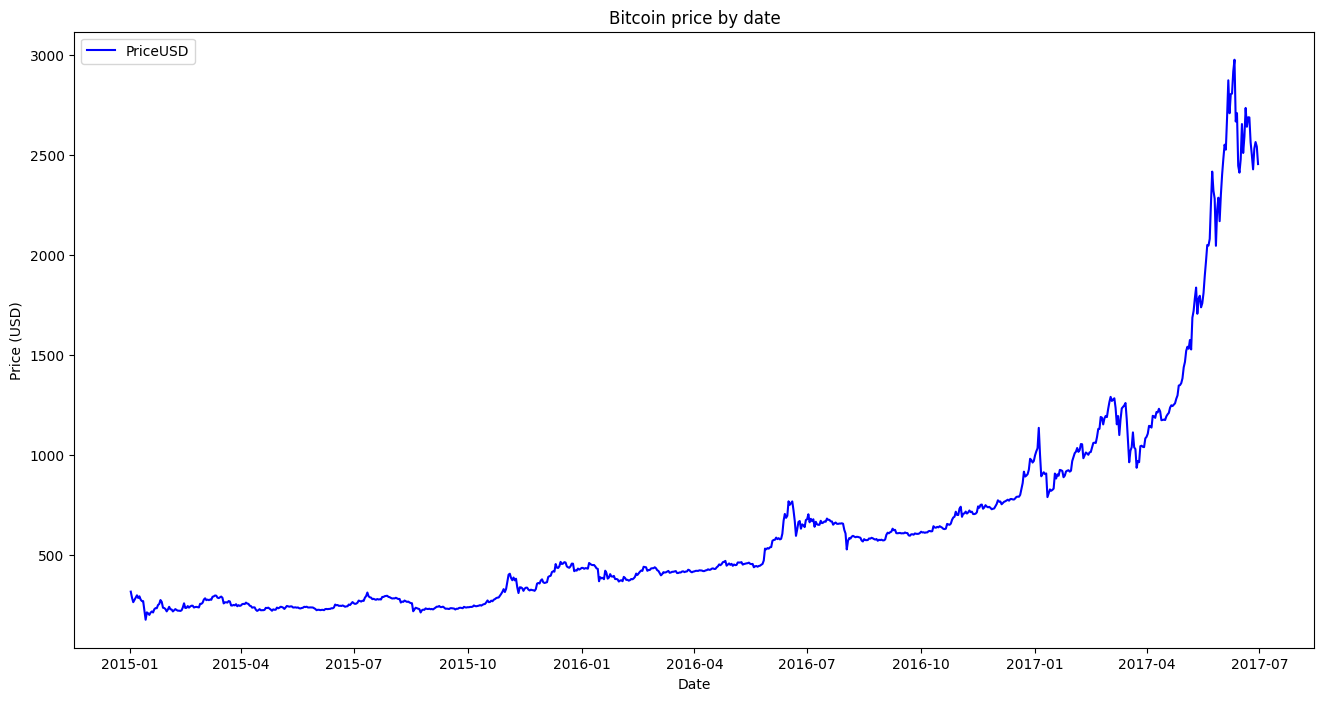

In [32]:
df = final(btc_df)

Dans la première partie de notre étude, nous avons cherché à identifier les différentes phases du cours du bitcoin. Pour ce faire, nous avons appliqué une méthode de détection de tendance à partir des données historiques du cours du bitcoin.

Plus précisément, nous avons calculé la médiane mobile sur cette fenêtre de 60 jours, qui nous a permis de déterminer une tendance générale pour cette période. Ensuite, nous avons calculé la variation autour de cette médiane mobile sur la même fenêtre de 60 jours.

$ variationAroundMedian = \frac{1}{n}\sum_{i=1}^{n} |price_i - median|$

où $n$ est la taille de la fenêtre et $price_i$ est le prix du Bitcoin pour le $i$-ème jour dans la fenêtre. $median$ est la médiane mobile calculée précédemment pour la fenêtre en question.
Cette variation nous a permis de mesurer l'amplitude de la volatilité du cours du bitcoin autour de sa tendance générale.

Ensuite, nous avons appliqué un seuil de 20 à cette variation pour déterminer les seuils de basse et haute volatilité. Si la valeur de la variation était supérieure à la médiane mobile + la variation autour de la médiane + 20, nous avons considéré que le cours était en phase haussière, et nous avons colorié cette période en vert. Si la valeur était inférieure à la médiane mobile + la variation autour de la médiane - 20, nous avons considéré que le cours était en phase baissière, et nous avons colorié cette période en rouge. Enfin, si la valeur était comprise entre ces deux seuils, nous avons considéré que le cours était en phase stagnante, et nous avons colorié cette période en bleu.

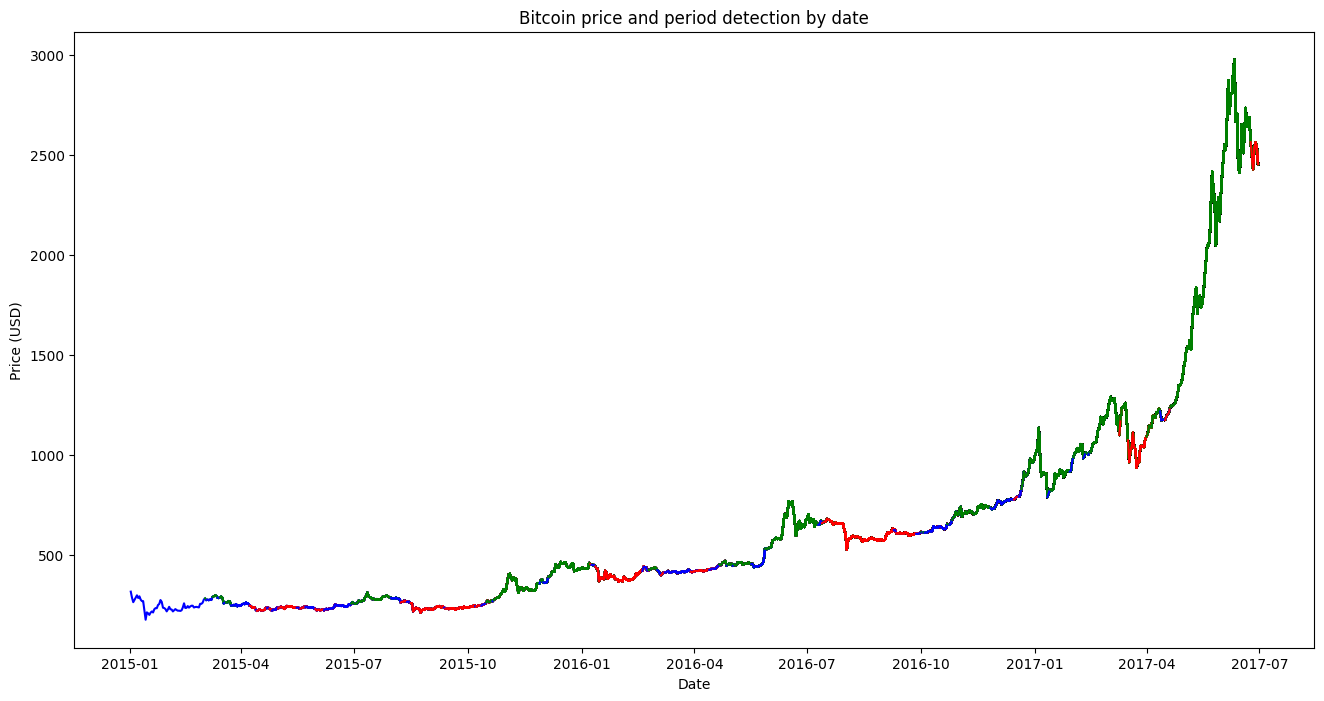

In [33]:
df = final(btc_df, period=True)

Nous allons maintenant choisir 2 phases haussières, 2 phases baissières et 2 phases stagnantes.
Pour les trouver nous allons prendre les 2 phases les plus longues (en jours) par tendance.

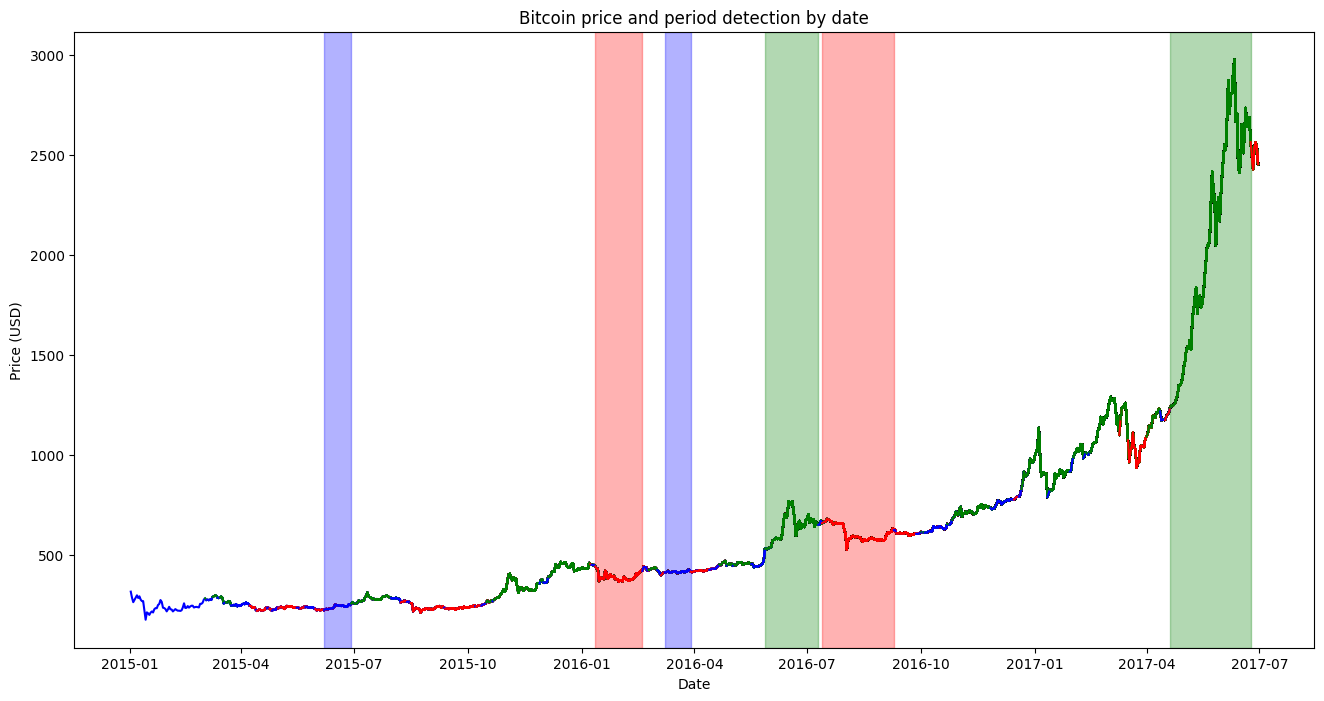

In [34]:
df, dates = final(btc_df, period=True, phase=True)

Nous allons regarder si le nombre de transactions et la somme des volumes entre les 100 acteurs ont un impact sur le cours du bitcoin.
Pour cela nous regardons sur une tranche de 7 jours avant chaque phase (on sélectionne la semaine avant chaque phase) la somme des valeurs et des interactions entre les 100 acteurs.

La fonction d'avant nous renvoie un dataframe avec un objet qui contient les 6 paires de dates avec leurs couleurs.

In [91]:
dates

[(Timestamp('2017-04-20 00:00:00'), Timestamp('2017-06-24 00:00:00'), 'g'),
 (Timestamp('2016-05-28 00:00:00'), Timestamp('2016-07-10 00:00:00'), 'g'),
 (Timestamp('2016-07-13 00:00:00'), Timestamp('2016-09-09 00:00:00'), 'r'),
 (Timestamp('2016-01-12 00:00:00'), Timestamp('2016-02-19 00:00:00'), 'r'),
 (Timestamp('2015-06-07 00:00:00'), Timestamp('2015-06-29 00:00:00'), 'b'),
 (Timestamp('2016-03-08 00:00:00'), Timestamp('2016-03-29 00:00:00'), 'b')]

Ici nous allons afficher la somme des interactions et de leurs valeurs par phases.

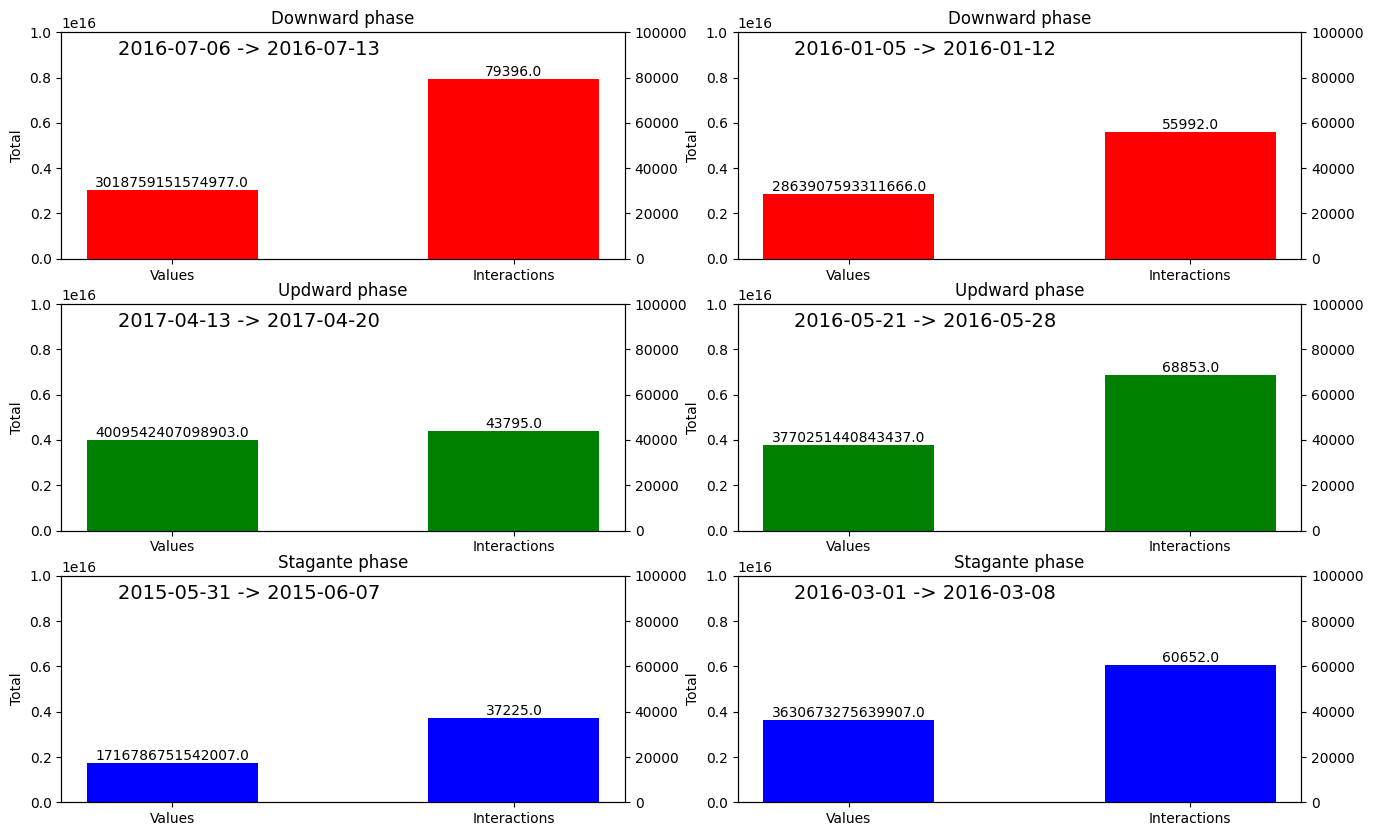

In [36]:
sum_interaction_values(dates)

Nous constatons que les volumes de bitcoins échangés sont plus importants avant une tendance haussière. Cependant, il n'y a pas de corrélation directe avec le nombre d'interactions ou la somme des volumes échangés par rapport aux différentes phases. Par conséquent, nous ne pouvons pas tirer de conclusion à partir de ces données.

In [92]:
(period_baissiere_start ,period_baissiere_end, _) = dates[2]
(period_haussiere_start ,period_haussiere_end, _) = dates[0]
(period_stagnante_start ,period_stagnante_end, _) = dates[4] 

delta = timedelta(days=7)
period_haussiere_end = period_haussiere_start
period_haussiere_start = period_haussiere_start - delta

period_baissiere_end = period_baissiere_start
period_baissiere_start = period_baissiere_start - delta

period_stagnante_end = period_stagnante_start
period_stagnante_start = period_stagnante_start - delta

listactor = ['Xapo.com', '269', '523', 'ePay.info_CoinJoinMess', '421', 'Poloniex.com', '354', '0', '999Dice.com']

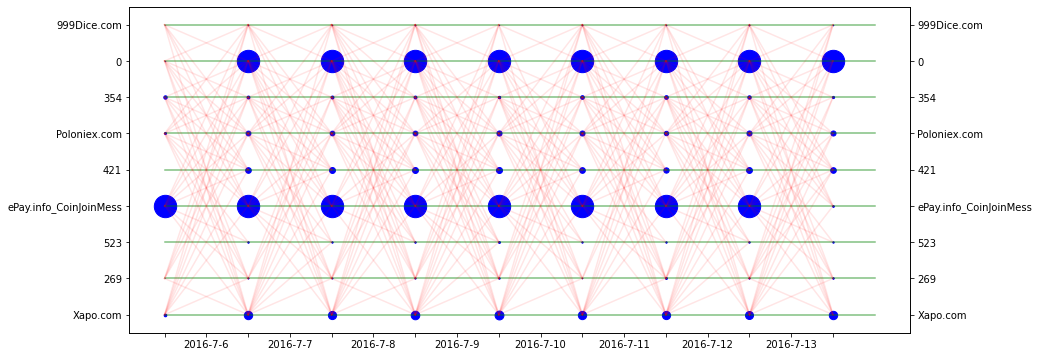

In [78]:
transaction_by_day(listactor, period_haussiere_start, period_haussiere_end)

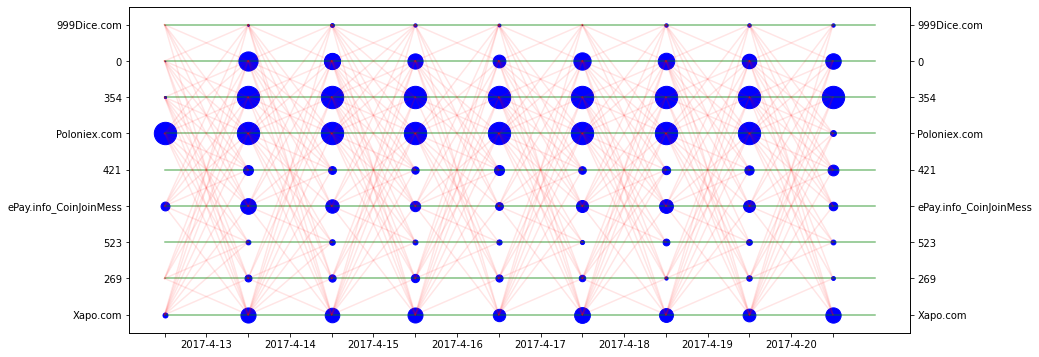

In [79]:
transaction_by_day(listactor, period_baissiere_start, period_baissiere_end)

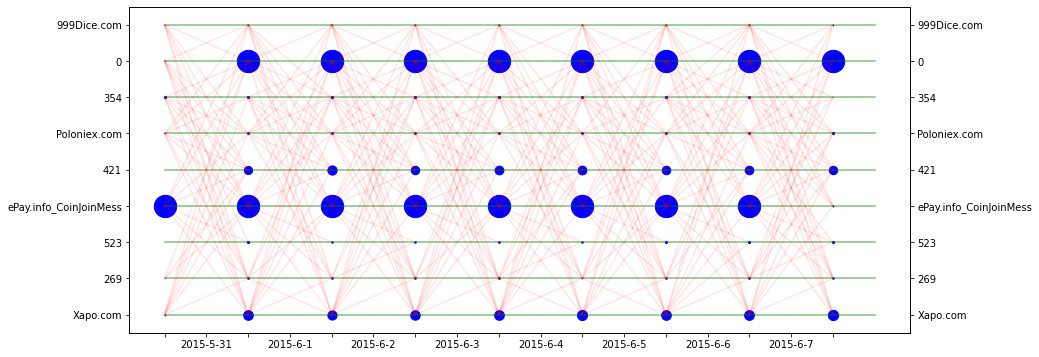

In [80]:
transaction_by_day(listactor, period_stagnante_start, period_stagnante_end)

Ces graphiques illustrent les interactions et la somme des valeurs de chaque interaction entre une liste d'acteurs. Cette liste est choisie par la fonction "get_best_actors", qui prend en paramètre deux dates et renvoie la liste des acteurs qui ont le plus échangé entre eux (acteurs communs aux meilleurs acteurs Sources et les meilleurs acteurs Target).

Sur l'axe des ordonnées, nous avons les différents acteurs choisis, et sur l'axe des abscisses, nous avons le temps en jours. Les interactions entre chaque acteur sont représentées en rouge, tandis que la valeur qu'ils ont reçue est représentée en bleu, la taille du marqueur bleu correspondant aux valeurs reçues.

Nous pouvons constater qu'avant une période haussière, il y a des échanges de valeurs plus importants entre ces acteurs que pendant la semaine précédant la phase baissière et stagnante. De plus, nous remarquons qu'il y a énormément d'interactions entre ces acteurs, quelle que soit la période.

Il est possible de voir que seule la valeur des transactions change suivant une période donnée. Nous pouvons en déduire que, par exemple, l'acteur 354 reçoit ou envoie un volume plus important de bitcoin avant cette période haussière. Cela peut indiquer qu'il a peut-être connaissance d'un indicateur suggérant que le prix du bitcoin allait augmenter.

Cependant, cela ne prouve en rien que cet acteur a influencé le cours du bitcoin.

# **1. Impact des intéractions entre les 100 acteurs sur le cours du bitcoin**

# **2. Impact volume sur le prix (Sans filtre)**

Nous allons maintenant proceder à une analyse du volume de transactions de 100 plus gros acteurs. Le but de cette partie est de voir si l'on peut essayer de prédire le cours du bitcoin, ou du moins sa tendance, en fonction du volume de transaction des plus gros acteurs. 

Commencons par tracer le graphique représentant la somme du volume journalier de transactions des plus gros acteurs. Un barre verte représente un volume positif, et une barre rouge un volume négatif.

$$Volume=\sum(received - (sent - estimated\_self\_spent))$$

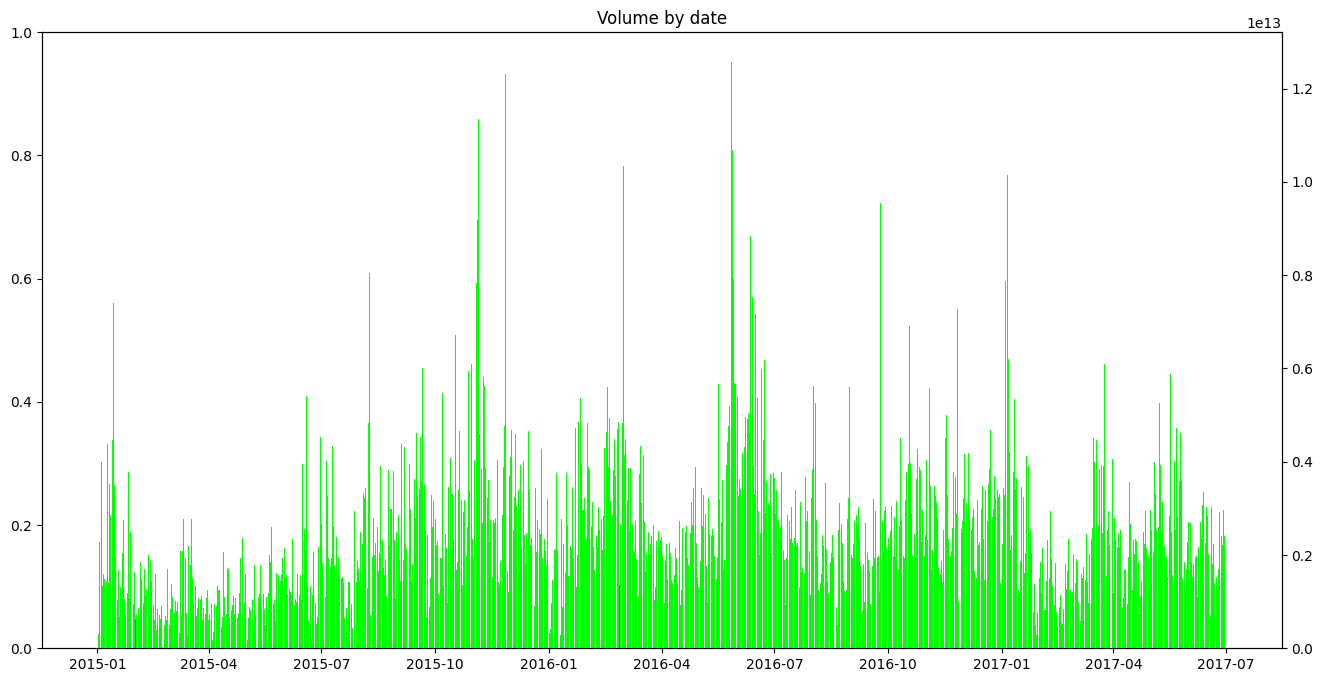

In [38]:
x = final(btc_df ,price=False, volume=True)

Nous pouvons remarquer à premier abord que, à l'exeption de deux jours, tous les jours ont un volume positif et très élevé. Tracons maintenant la courbe du cours de bitcoin contre le volume afin d'essayer de détecter des motifs récurents.

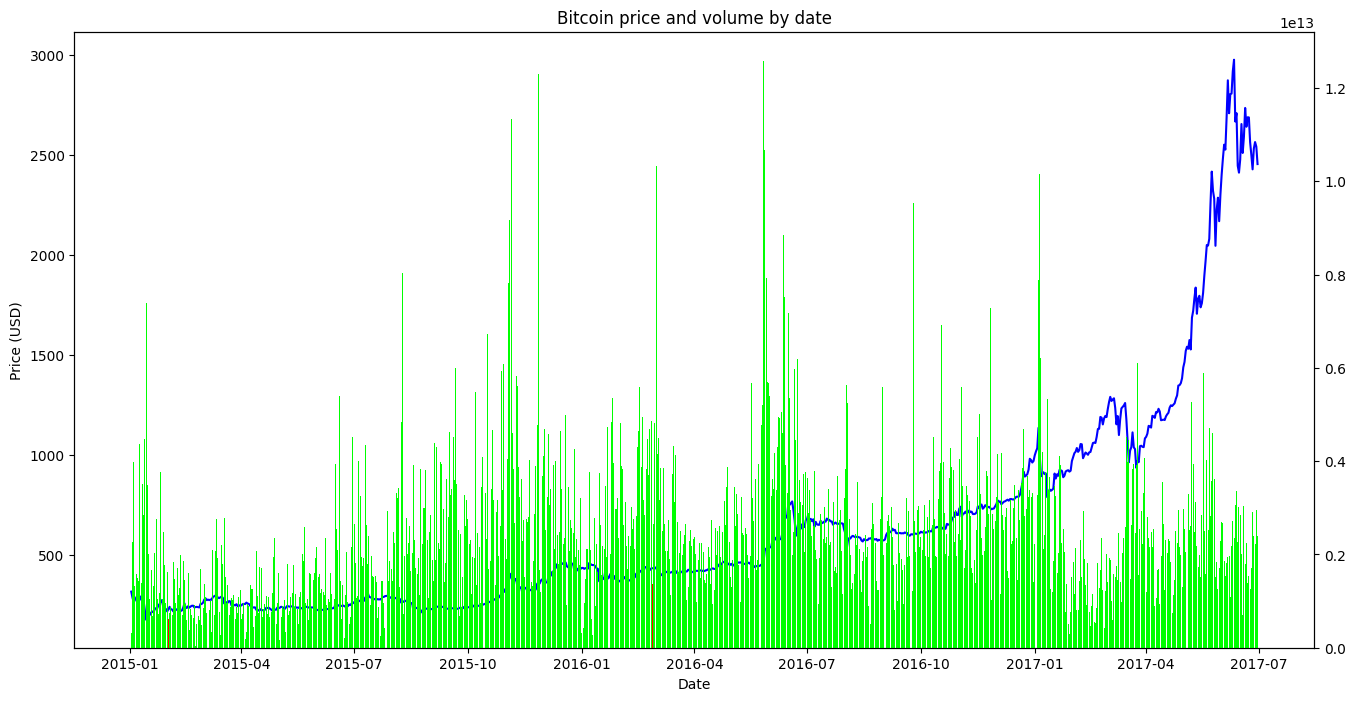

In [39]:
x = final(btc_df ,price=True, volume=True)

On observe aucun motif récurent, et les données n'ont pas grand sens. Le volume est positif et très élevé tous les jours, même en période baissière. Il faut donc songer a netoyer les donnés afin de pouvoir en tirer des conclusions pértinentes.

Avant de procèder a un filtrage des donnés, analysons rapidement le profit total sur la période étudiée des 100 plus grands acteurs:

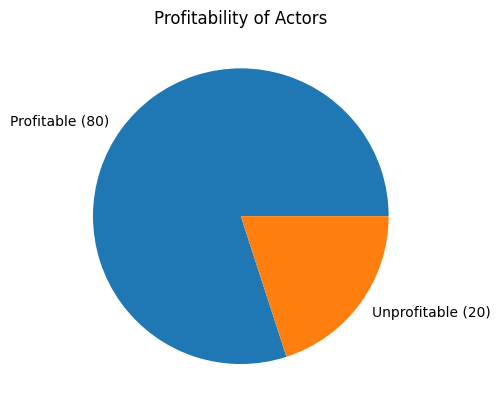

In [40]:
x = plot_profitability(actors_df)

Nous observons 80 acteurs en profit contre 20 acteurs  en déficit. En vue de la nature très haussiere du bitcoin sur le total de la période étudiée, ce résultat est coérent avec l'analyse du volume. En effet, un acteur qui ait acheté régulierement du bitcoin sans se soucier de son cours (avec une stratégie de type Dollar Cost Averaging) se verrait avec de lourds profits.

Procédons maintenant à un filtrage des données.

# **Impact volume sur le prix (Avec filtre)**

## **Description du filtre**

Afin de filtrer les donnés, nous alons utiliser la méthode IQR.

La méthode IQR (interquartile range, ou écart interquartile en français) est une technique  utilisée pour identifier et éliminer les valeurs aberrantes (ou cas extrêmes) dans un ensemble de données. Elle consiste à calculer la différence entre le troisième et le premier quartile d'une distribution de données, également appelée étendue interquartile (EI), puis à définir une limite supérieure et inférieure pour les valeurs plausibles en multipliant cette EI par un facteur constant k (ici 1,5). Les valeurs qui se situent en dehors de ces limites sont considérées comme des valeurs aberrantes et peuvent être supprimées de l'ensemble de données.

Voici un support visuel pour mieux comprendre cette methode.


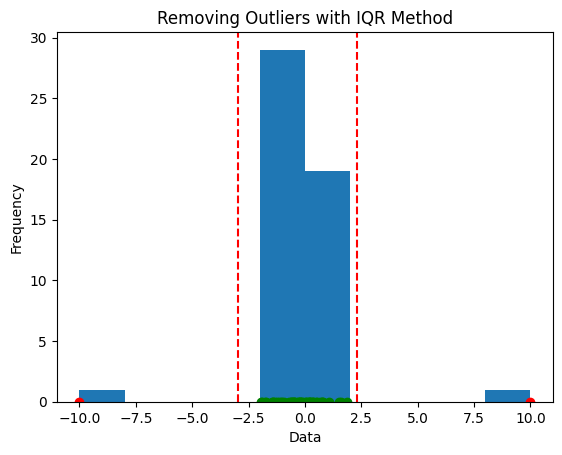

In [41]:
visual_iqr_method()

### **Acteurs restants**

Analisons rapidement le acteurs réstants dans notre jeux de donnés filtré.

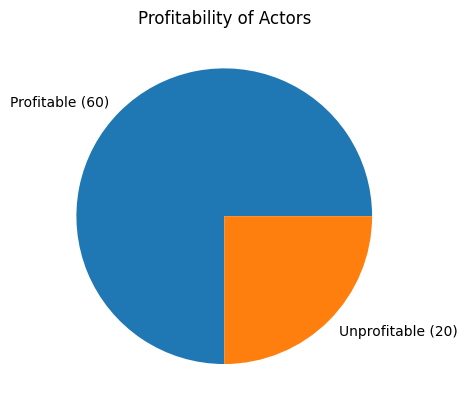

In [42]:
profit_bdba_df = profit_by_day_by_actor(actors_df)
corrected_df = remove_extreme_players(profit_bdba_df)
identities_tk = identities_to_keep_corrected(corrected_df)
x = plot_profitability(actors_df,identities_tk)

Sans surprise, nous observons que les cas extremes etaient des acteurs qui étaient parmis les plus profitables. Nous avons maintenant une distribution de 60 acteurs profitables contre 20 acteurs non profitables.

Analysons maintenant le volume sur les acteurs réstants.

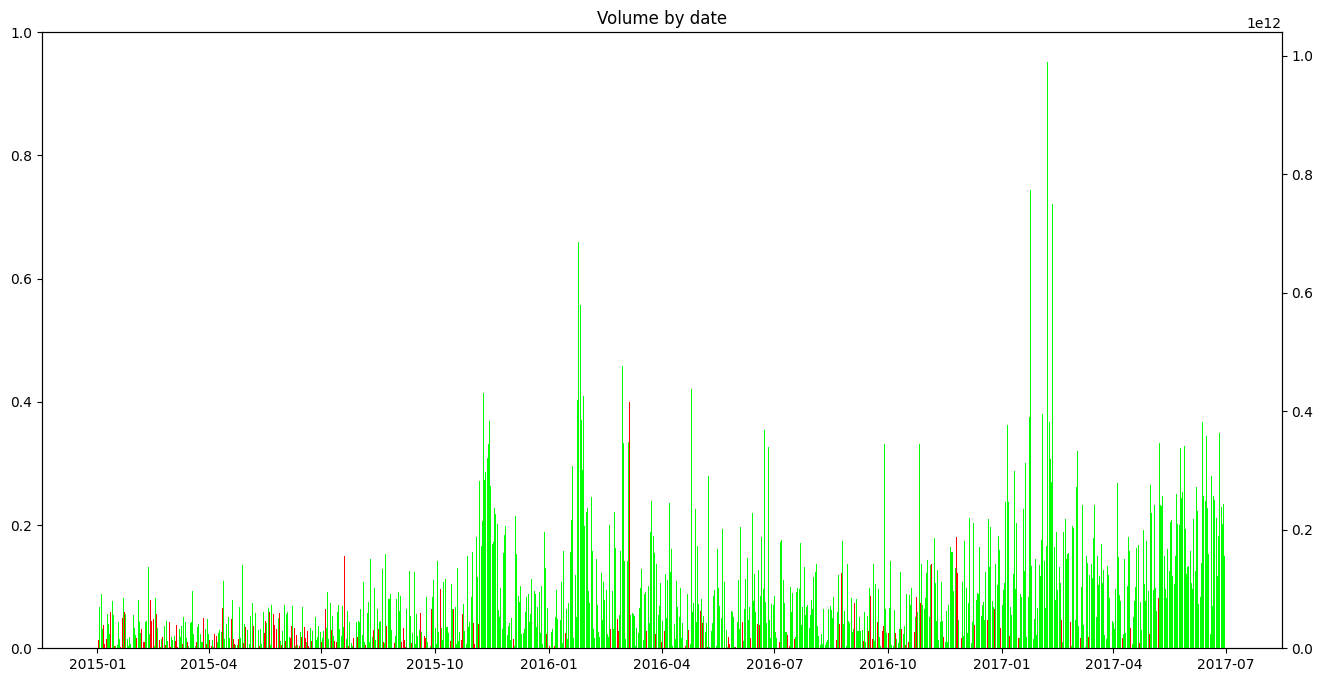

In [43]:
x = final(btc_df ,price=False, volume=True, corrected=True)

Le résultat est beaucoup plus consistant avec ce a quoi on pourrait s'attendre: une minorité de jours où le volume fut négatif, et certaint grand pics de volume liés aux périodes de forte activité. Comparons avec le cours du bitcoin.

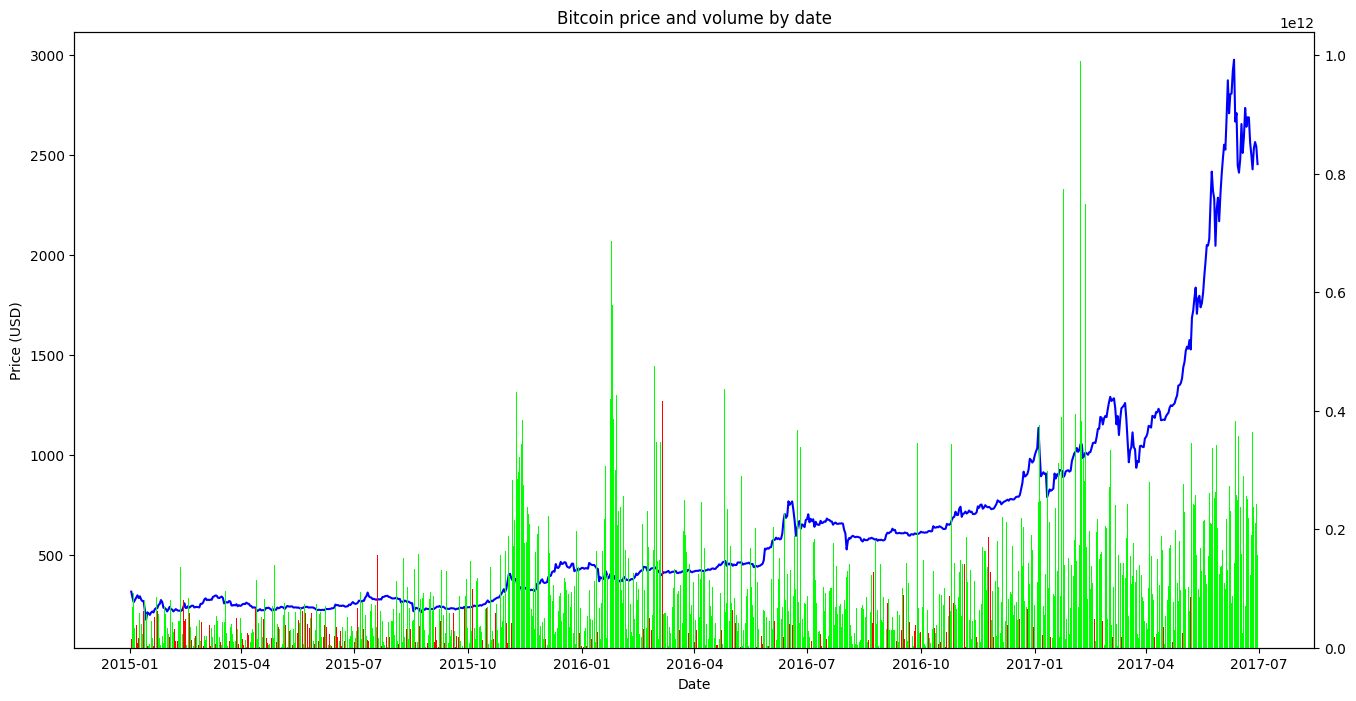

In [44]:
x = final(btc_df, volume=True, corrected=True)

On observe que les pics de volume positifs précedent souvent une période de croissance pour le bitcoin. Confirmons avec la détéction des phases:

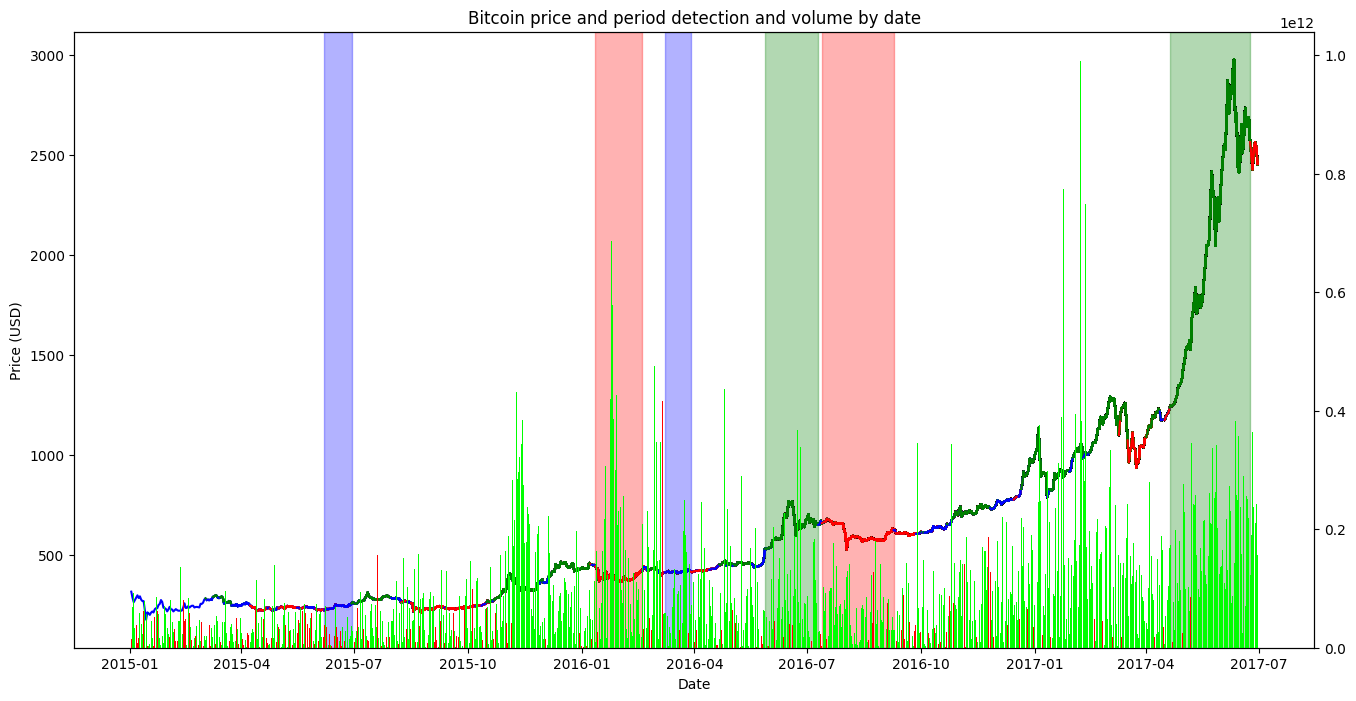

In [45]:
x = final(btc_df, volume=True, corrected=True, phase=True,period=True,n=0)

Nous observons que la plupart des fois, un gros pic de volume positif signifie soit le début d'une phase verte, soit la fin d'une phase rouge. Cepandant, cela reste assez anecdotique, et cette information demeure difficilement utilisable de façon profitable dans un contexte réel. Faisons mieux.

# **Volume: allons plus loin**

## **VWMA**

Essayons maintenant de construire un indicateur technique qui pourrait nous aider à prédire le cours du bitcoin grace aux informations dequelles nous disponsons. Commencons par aficher une moyenne mobile (MM, ou moving average en anglais). 

La moyenne mobile est un indicateur qui indique la moyenne du prix sur une période choisie. Par exemple, pour l'indicateur MM30, chaque point va répresenter la moyenne du prix sur les 30 derniers jours. Affichons le cours du bitcoin avec un indicateur MM30.

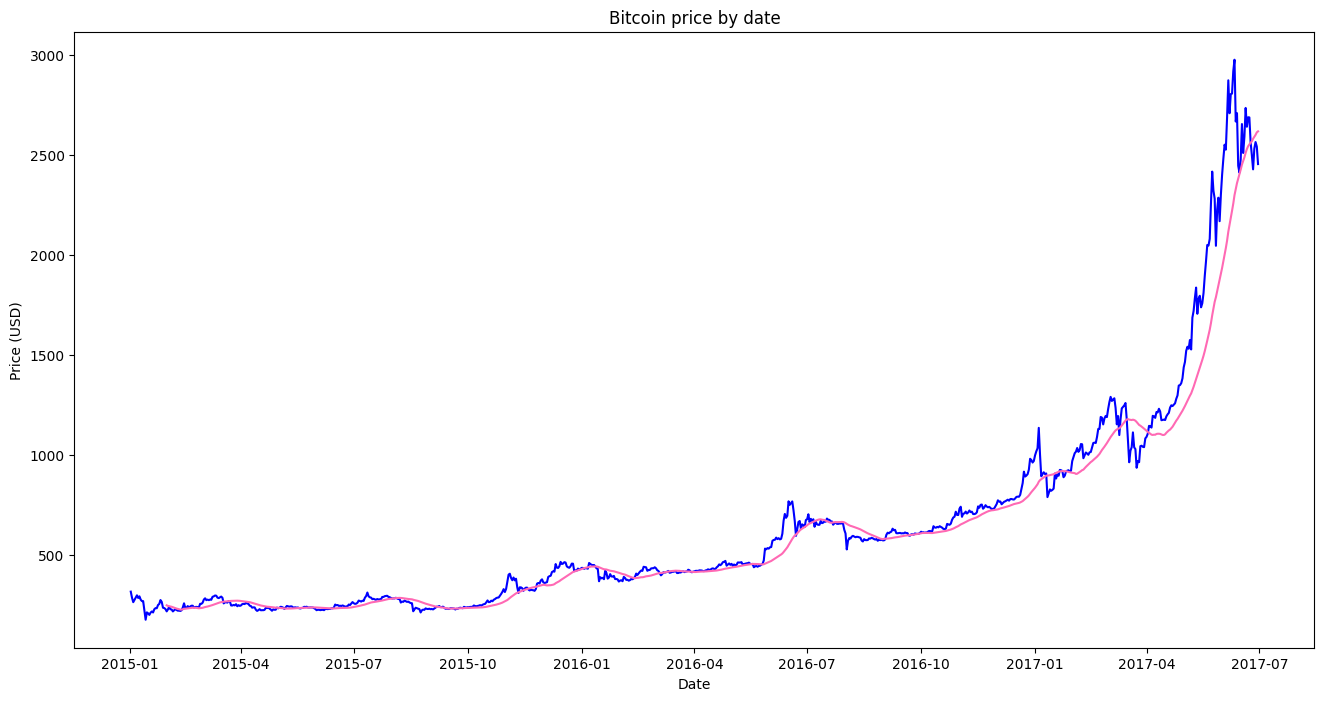

In [46]:
x = final(btc_df, mean=True)

Ameliorons maintenant cet indicateur en le pondérant par le volume journalier. Cette technique s'appelle la Moyenne Mobile Pondéree par le Volume (ou volume wheighted moving average en anglais). Tracons le MMPV en fonction du volume.

$$VWMA = \frac{\sum_{i=n-w+1}^{n} P_i V_i}{\sum_{i=n-w+1}^{n} V_i}$$

P_i = prix du bitcoin pour le jour i
V_i = Volume pour le jour i
W = Fenetre sur laquelle la moyenne est calculée

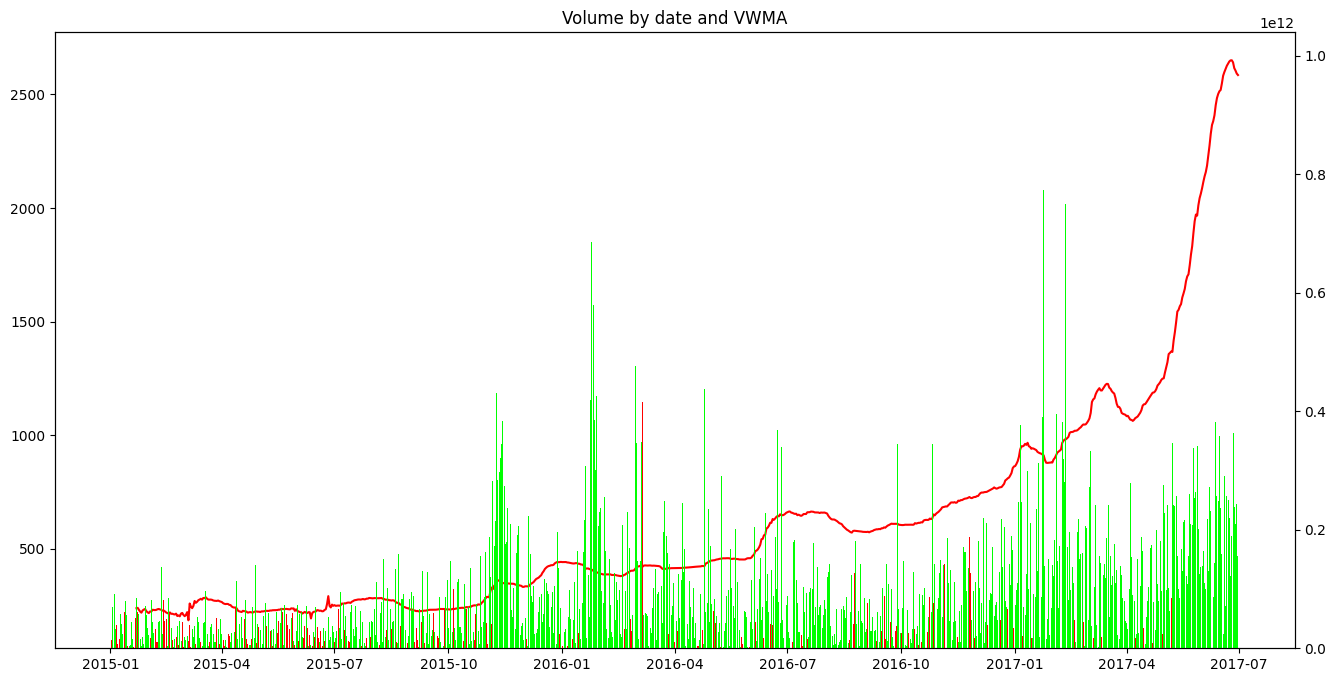

In [47]:
x = final(btc_df,price=False,vwma=True,volume=True, corrected=True)

Et maintenant en fonction du prix.

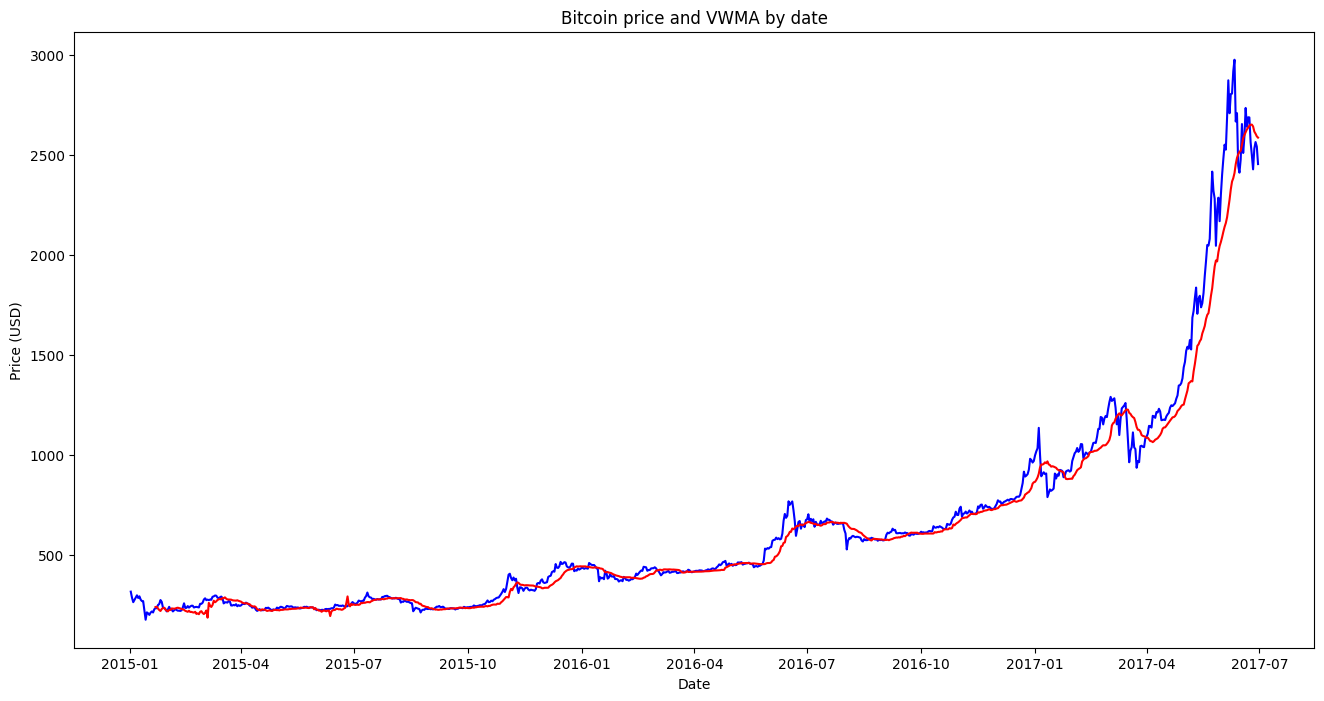

In [48]:
x = final(btc_df,vwma=True)

# **Le crossover**

La moyenne mobile et surtout la moyenne mobile pondéree par le volume sont des indicateurs qui visent a détecter les changements de tendance dans un marché. Nous allons donc définir une stratégie simple afin de voir si l'on peut se baser sur le volume des grands acteurs pour prédire avec un certain succes les changements de tendance sur le cours du bitcoin.

Nous allons donc observer le cours du bitcoin sur deux types de périodes différentes: Un croisement bas, c'est à dire le prix passe en dessous de sa MMPV, et un croisement haut, c'est à dire le prix passe au dessus de sa MMPV. Voyons.

Une période commence par un croisement et se termine lorsque le croisement oposé a lieu.

## Croisement bas

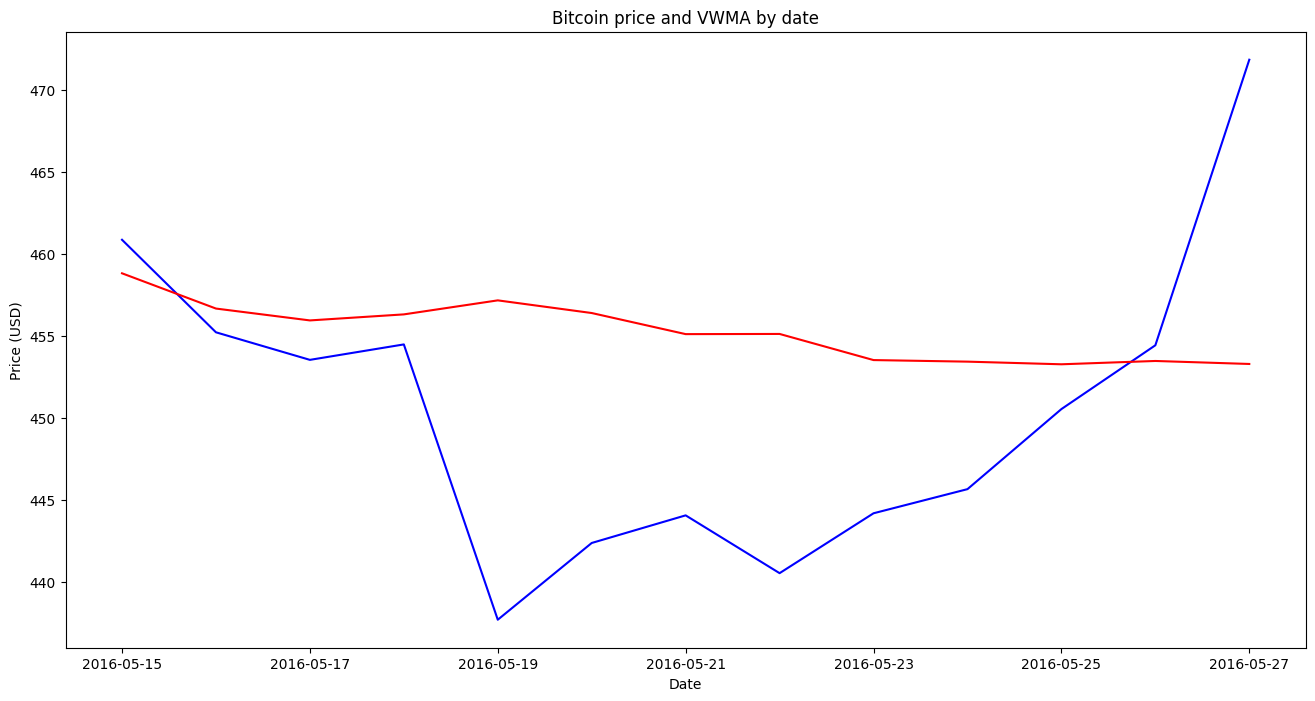

In [58]:
x = final(btc_df, vwma=True,date_start="2016-05-15", date_end="2016-05-27")

## Croisement haut

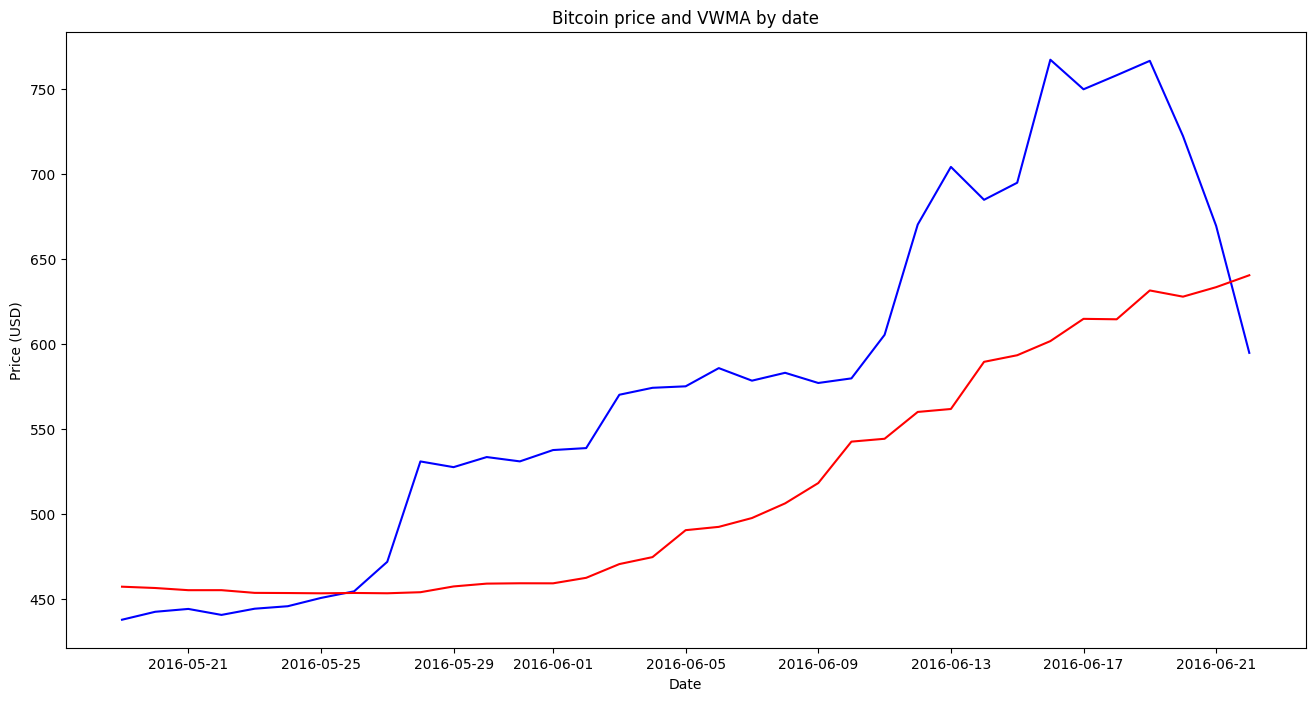

In [65]:
x = final(btc_df, vwma=True,date_start="2016-05-19", date_end="2016-06-22")

/tmp/ipykernel_74/701842295.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'movement'] = df['PriceUSD'].pct_change()


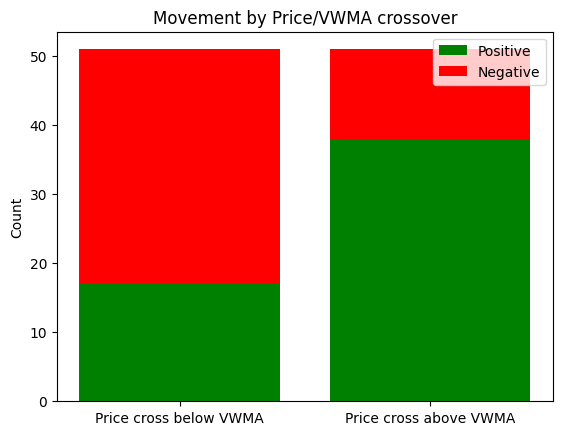

In [133]:
x = weighted_volume(actors_df)
draw_vwma_results(x)

Les résultats sont claires. Lors d'un croisement bas, le bitcoin va suivre une tendance baissiere une majorité des fois. Lors d'un croisement  haut, il va suivre une tendance haussière la majorité des fois. Ainsi, en analysant les volume journalier des 100 plus gros acteurs, nous arrivons a prédire avec un certain niveau de sureté, grace a la stratégie de croisement du prix et de sa MMPV, si une période va être baissiere ou haussiere. Il faut cependant garder en tête que la pérformance passée n'est pas indicatrice de performance future, surtout dans les marchés financiers.